# In this notebook, we will demonstrate how the emulation of isochrones from CNF<sub>dwarf</sub>

In [1]:
import os, sys
import numpy as np
import scipy as sp
import scipy.stats
import corner
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch, zuko
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import torch.utils.data as utils
from tqdm import tqdm_notebook as tqdm
from matplotlib import colors as clr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from copy import copy
from matplotlib.lines import Line2D

print(torch.__version__, zuko.__version__)

assert zuko.__version__ == '0.3.2'

2.0.1+cu117 0.3.2


# Loading pre-trained flow

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

loadpath = os.path.split(os.getcwd())[0] + '/pretrained_flows/cnf_dwarf.checkpoint'
checkpoint = torch.load(loadpath, map_location={'cuda:5': device})

flow = zuko.flows.NSF(features=9,  context=6, transforms=10, hidden_features=[256] * 10).to(device)
flow.load_state_dict(checkpoint['model_state_dict'])

print("=> loaded checkpoint (epoch {} - loss {})" .format(checkpoint['epoch'], checkpoint['loss']))

=> loaded checkpoint (epoch 20400 - loss -44.47920018736668)


# Loading in the training grid, selecting dwarfs, and creating scaler functions for observables

In [3]:
data = pd.read_parquet(os.path.split(os.getcwd())[0] + '/grid/p-mode.parquet')

dwarf_cond =  (data.nu_max.values > 300) & (data.eps > 0) &\
(data.dnu01 > -4.5) & (data.dnu01 < 15) & \
(data.dnu02 > 0)  

teff_scaler = StandardScaler()
d01_scaler = StandardScaler()
mms_shell_scaler = MinMaxScaler()
mms_core_scaler = MinMaxScaler()

# Visualization 1: Individual isochrones

## Here, we want to use input parameters $\mathbf{x}$ across the entire grid to condition the normalizing flow. We then sample from the flow, we should give us the distribution of observables from the grid.

### $\mathbf{x} = [M, \log_{10}Z, Y, \alpha, f_{\mathrm{ov, env}}, f_{\mathrm{ov, core}}]$
### $\mathbf{y} = [T_{\mathrm{eff}}, \Delta\nu, \delta\nu_{01},  \delta\nu_{02},  \delta\nu_{03}, \epsilon, \nu_{\mathrm{max}}, R, \tau]$

## On top of making a selection using $\mathbf{x}$, we want to make a selection using $\mathbf{y}$. In this case, we want to select using age ($\tau$).

## First, we apply transformations to each vector following how they were transformed during training of the flow.

In [4]:
x_mass = data.star_mass.values[dwarf_cond]
x_feh = np.log10(data.Zinit.values[dwarf_cond])
x_init_helium = data.Yinit.values[dwarf_cond]
x_alpha = data.amlt.values[dwarf_cond]
x_ov_env = mms_shell_scaler.fit_transform(data.fov_shell.values[dwarf_cond].reshape(-1,1)).squeeze()
x_ov_core = mms_core_scaler.fit_transform(data.fov_core.values[dwarf_cond].reshape(-1,1)).squeeze()


# 6D vector X is mass, Z, Y, alpha, f_ov_env, f_ov_env, and f_ov_core

y_teff = data.log_Teff.values[dwarf_cond]
y_teff_scaled = teff_scaler.fit_transform(y_teff.reshape(-1,1)).squeeze()
y_dnu_scaled = np.log10(data.Dnu_freq.values[dwarf_cond])
y_d01 = data.dnu01.values[dwarf_cond]
y_d01_scaled = d01_scaler.fit_transform(y_d01.reshape(-1,1)).squeeze()
y_d02 = data.dnu02.values[dwarf_cond]
y_d02_scaled = np.log10(y_d02)
y_d03 = data.dnu03.values[dwarf_cond]
y_d03_scaled = np.log10(y_d03 + 3)
y_eps = data.eps.values[dwarf_cond]
y_numax_scaled = np.log10(data.nu_max.values[dwarf_cond])
y_radius_scaled = np.log10(data.radius.values[dwarf_cond])
y_age = (data.star_age.values[dwarf_cond])/1e9
y_age_scaled = np.log10((y_age))

# 9D vector is Teff, DeltaNu, d01, d02, d03, epsilon, numax, radius, and age.

## Here, we present isochrones.

### Let's first define a helper function to sample points given input parameters $\mathbf{x}$

In [5]:
def infer_samples(flow, cvar, percentile=None):
    """
    Infer samples from a given flow model conditioned on a specific variable.

    This function infers samples from a specified flow model based on a conditioning variable. It can also filter 
    these samples based on a percentile of their log probabilities, effectively trimming the less probable samples.

    Parameters
    ----------
    flow : torch.nn.Module
        The Zuko flow model from which samples are to be drawn.
    cvar : array_like
        The conditioning variable on which the flow model samples are conditioned. This should be compatible with the input
        expected by the `flow` model.
    percentile : float, optional
        The percentile of log probabilities below which samples are discarded. If `None` (the default), all samples
        are returned.

    Returns
    -------
    numpy.ndarray
        The inferred samples. If `percentile` is not None, only samples with log probabilities above the specified
        percentile are returned.
    numpy.ndarray, optional
        The indices of the samples returned. This is only returned if `percentile` is not None.

    """
    with torch.no_grad():
        # Generate samples and log probabilities from the flow model
        ss2, ss_logprobs = flow(torch.Tensor(cvar).to(device)).rsample_and_log_prob((1,))
        ss_logprobs = ss_logprobs.data.cpu().numpy().squeeze()
        ss2 = ss2.data.cpu().numpy().squeeze()

    # If percentile is specified, filter samples based on their log probabilities
    if percentile is not None:
        condition = ss_logprobs > np.percentile(ss_logprobs, percentile)
        return ss2[condition], np.arange(len(ss2))[condition]
    else:
        return ss2

## We let mass freely vary but keep the other input parameters fixed. We then select all emulated models with an age within 0.01 Gyr of pre-defined ages.

In [11]:
age_select = [0.2, 2, 4, 8, 10] # user-defined

num_marginals = 500000

ss_vec, keep_vec = [], []

for i in range(len(age_select)): # for each age, we sample from the flow

    fehvar = -1.9
    massvar = np.random.uniform(low=min(x_mass), high=max(x_mass), size=num_marginals) # let mass float because it is correlated with age
    heliumvar = 0.277
    alfvar = 1.9
    ovshellvar = 0.5
    ovcorevar = 0.5

    cv = np.ones((num_marginals, 6))
    cv[:,0] = massvar
    cv[:,1] = fehvar
    cv[:,2] = heliumvar
    cv[:,3] = alfvar
    cv[:,4] = ovshellvar
    cv[:,5] = ovcorevar

    cvar = torch.Tensor(cv).to(device)
    ss, keep_indices = infer_samples(flow, cvar, percentile = 5) # keep_indices tracks outliers to discard
    ss_vec.append(ss)
    keep_vec.append(keep_indices)

ss_vec = np.concatenate(ss_vec)
keep_vec = np.concatenate(keep_vec)
sampled_ages = 10**ss_vec[:,-1]  # This is a vector of emulated ages collected from the sampling. Not filtered yet.

## We now visualize the isochrones across evolutionary diagrams. This yields Figure 7 from the paper.

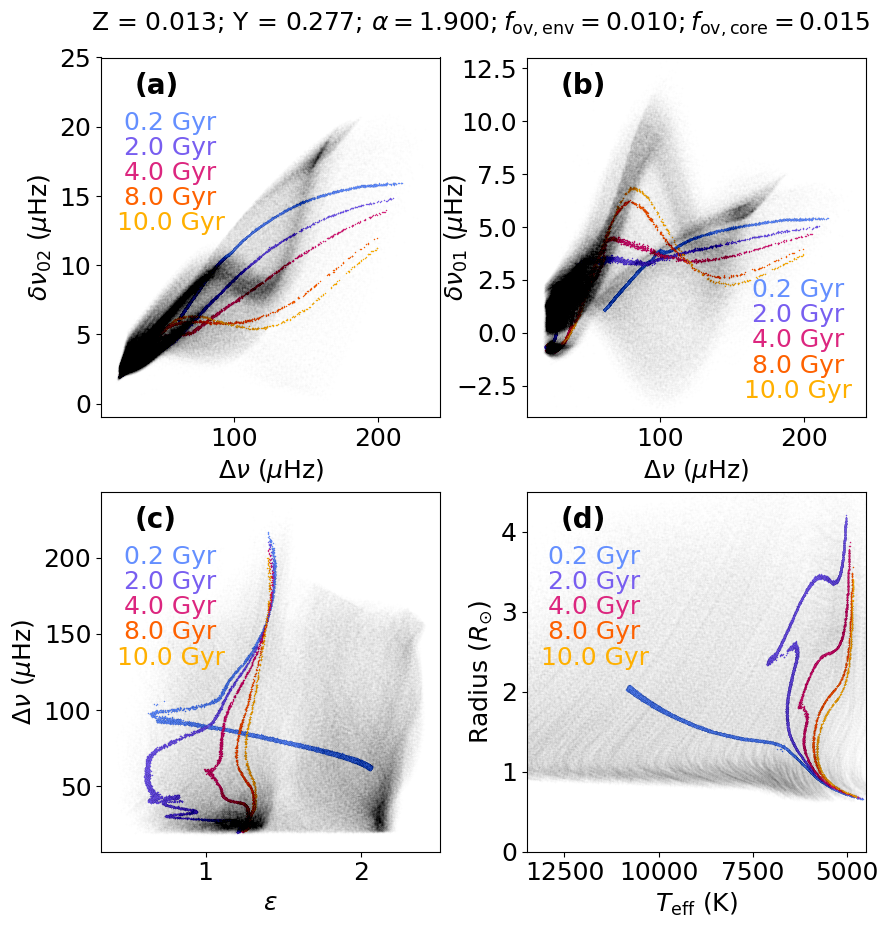

In [13]:
fig = plt.figure(figsize=(9,9))
ax1, ax2 = fig.add_subplot(221), fig.add_subplot(222)
ax3, ax4 = fig.add_subplot(223), fig.add_subplot(224)
colors = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
axlabel = ['(a)', '(b)', '(c)', '(d)']
downsamp = 1
fs = 18
alpha=0.005
lw=0.015


for i,a in enumerate(age_select):
    
    ## Here we select only emulated models with ages near the user-defined ages ##
    select_indices = np.isclose(sampled_ages, a, atol=0.01)
    ax1.scatter(10**ss_vec[select_indices,1], 10**ss_vec[select_indices,3], s=1, c=colors[i], edgecolor='k', lw=lw)
    ax2.scatter(10**ss_vec[select_indices,1],
                d01_scaler.inverse_transform(ss_vec[select_indices,2].reshape(-1,1)).squeeze(), s=1, 
                c=colors[i], edgecolor='k', lw=lw)
    ax3.scatter(ss_vec[select_indices,5], 10**ss_vec[select_indices,1], s=1, c=colors[i], edgecolor='k', lw=lw)
    ax4.scatter( 10**teff_scaler.inverse_transform(ss_vec[select_indices,0].reshape(-1,1)).squeeze(), 
                10**ss_vec[select_indices,-2], s=1, c=colors[i], edgecolor='k', lw=lw)

    ax1.text(s='%.1f Gyr' %(age_select[i]),
        x=0.205, y=0.8 - i*0.07, ha='center', fontsize=fs, color=colors[i], transform=ax1.transAxes)
    ax2.text(s='%.1f Gyr' %(age_select[i]),
        x=0.8, y=0.335 - i*0.07, ha='center', fontsize=fs, color=colors[i], transform=ax2.transAxes)   
    ax3.text(s='%.1f Gyr' %(age_select[i]),
        x=0.205, y=0.8 - i*0.07, ha='center', fontsize=fs, color=colors[i], transform=ax3.transAxes) 
    ax4.text(s='%.1f Gyr' %(age_select[i]),
        x=0.2, y=0.8 - i*0.07, ha='center', fontsize=fs, color=colors[i], transform=ax4.transAxes) 

    
ax1.scatter(10**y_dnu_scaled[::downsamp], 10**y_d02_scaled[::downsamp], s=1, c='k', alpha=alpha)
ax2.scatter(10**y_dnu_scaled[::downsamp], y_d01[::downsamp], s=1, c='k', alpha=alpha)
ax3.scatter(y_eps[::downsamp], 10**y_dnu_scaled[::downsamp],s=1, c='k', alpha=alpha)
ax4.scatter(10**y_teff[::downsamp], 10**y_radius_scaled[::downsamp],s=1, c='k', alpha=alpha)
ax1.set_xlabel('$\\Delta\\nu$ ($\\mu$Hz)', fontsize=fs)
ax1.set_ylabel('$\\delta\\nu_{02}$ ($\\mu$Hz)', fontsize=fs)
ax2.set_xlabel('$\\Delta\\nu$ ($\\mu$Hz)', fontsize=fs)
ax2.set_ylabel('$\\delta\\nu_{01}$ ($\\mu$Hz)', fontsize=fs, labelpad=-10)
ax3.set_ylabel('$\\Delta\\nu$ ($\\mu$Hz)', fontsize=fs)
ax3.set_xlabel('$\\epsilon$', fontsize=fs)
ax4.set_ylabel('Radius $(R_{\\odot})$', fontsize=fs)
ax4.set_xlabel('$T_{\\mathrm{eff}}$ (K)', fontsize=fs)
ax1.set_ylim(-1, 25)
ax2.set_ylim(-4, 13)
ax4.set_ylim(0., 4.5)
ax4.set_xlim(13500, 4500)

for i, ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.text(s= axlabel[i], fontsize=fs+2, transform=ax.transAxes, color='k',
            fontweight='bold', x=0.1, y=0.9)
    
    
fig.text(s='Z = %.3f; Y = %.3f; $\\alpha = %.3f; f_{\mathrm{ov, env}} = %.3f; f_{\mathrm{ov, core}} = %.3f$'\
         %(10**fehvar, heliumvar, alfvar,
           mms_shell_scaler.inverse_transform(np.array(ovshellvar).reshape(-1,1)).squeeze(),
          mms_core_scaler.inverse_transform(np.array(ovcorevar).reshape(-1,1)).squeeze()),
        x=0.54, y=1.0025, ha='center', fontsize=fs, color='k')


plt.tight_layout(w_pad=2, h_pad=0.5)
plt.show()


# Visualization 2: Continua of isochrones

## We can easily show a collection of isochrones by marginalizing over input parameters at any user-defined series of ages. For this demonstration, we marginalize over mass and metallicity.

### First, we define a 10x10 bivariate color map.

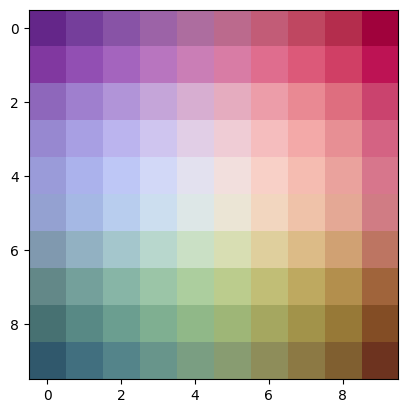

In [8]:
import xycmap

xcmap = plt.cm.coolwarm
ycmap = plt.cm.PiYG  
n = (10, 10)  
cmap = xycmap.mean_xycmap(xcmap=xcmap, ycmap=ycmap, n=n)
plt.imshow(cmap)
plt.show()

## We also describe a helper function for plotting

In [6]:
def bivariate_d01d02eps(var1, var2, d01, d02, eps, dnu, teff, radius,
                        conditional_name, conditional_unit, conditional_val,
                        var1name, var2name, cmap, colors, fs = 12, save_folder=None):
    
    """
    Plots a set of bivariate scatter plots for astronomical data, including
    asteroseismic and stellar parameters. The function creates four subplots, each
    showing different aspects of the data provided, and optionally saves the plot
    to a specified folder.

    Parameters:
        var1 (array-like): First marginalized input parameter.
        var2 (array-like): Second marginalized input parameter.
        d01 (array-like): Small frequency separation for l=0 and l=1 modes.
        d02 (array-like): Small frequency separation for l=0 and l=2 modes.
        eps (array-like): p-mode frequency offset used in asteroseismology.
        dnu (array-like): Large frequency separation.
        teff (array-like): Effective temperature.
        radius (array-like): Stellar radius in solar radii.
        conditional_name (str): Name of the condition applied for the plot (e.g., 'Mass' or 'Age').
        conditional_unit (str): Units of the conditional variable.
        conditional_val (float): Value of the conditional variable used in annotations.
        var1name (str): Name to be used as a label for `var1`.
        var2name (str): Name to be used as a label for `var2`.
        cmap (Colormap): Matplotlib colormap instance used for coloring data points.
        colors (array-like): Colors for the data points, usually derived from a colormap.
        fs (int, optional): Font size used for text in the plots. Defaults to 12.
        save_folder (str, optional): Path to the folder where the plot should be saved. If None, the plot is shown instead of being saved.

    Returns:
        None: This function does not return any values but generates a matplotlib plot or saves the plot to a folder.

    """
    
    fig = plt.figure(figsize=(9,9))
    ax1, ax2 = fig.add_subplot(221), fig.add_subplot(222)
    ax3, ax4 = fig.add_subplot(223), fig.add_subplot(224)

    downsamp = 1

    ax1.scatter(10**y_dnu_scaled[::downsamp], 10**y_d02_scaled[::downsamp], s=1, c='k', alpha=0.025)
    ax1.scatter(dnu, d02, s=2, c=colors)
    ax1.set_xlabel('$\\Delta\\nu$ ($\\mu$Hz)',  fontsize=fs)
    ax1.set_ylabel('$\\delta\\nu_{02}$ ($\\mu$Hz)',  fontsize=fs)
    ax1.text(x=0.31, y=0.575, s='%s %.2f %s' %(conditional_name, conditional_val, conditional_unit),
             transform = ax1.transAxes,
             fontsize=fs-4, ha='right')
    ax1.tick_params(axis='both', which='major', labelsize=fs)
    ax1.set_xlim((7.2167596864755765, 223.20284723531213))
    ax1.set_ylim((-0.7243560209115851, 21.946998024114134))
    ax1.text(x=0.85, y=0.1, s='(a)', fontweight='bold',  fontsize=fs,
            transform=ax1.transAxes)
    
    ax2.scatter(10**y_dnu_scaled[::downsamp], y_d01[::downsamp], s=1, c='k', alpha=0.05)
    ax2.scatter(dnu, d01,
                s=2, c=colors)

    ax2.set_xlim((-11.62380321284918, 244.10001689718473))
    ax2.set_ylim((-5.309158061681022, 14.312067750913858))
    ax2.set_xlabel('$\\Delta\\nu$ ($\\mu$Hz)',  fontsize=fs)
    ax2.set_ylabel('$\\delta\\nu_{01}$ ($\\mu$Hz)',  fontsize=fs, labelpad=-1.75)
    ax2.tick_params(axis='both', which='major', labelsize=fs)   
    ax2.text(x=0.1, y=0.9, s='(b)', fontweight='bold',  fontsize=fs,
            transform=ax2.transAxes)
    
    ax3.scatter(y_eps[::downsamp], 10**y_dnu_scaled[::downsamp],s=1, c='k', alpha=0.05)
    ax3.scatter(eps, dnu, s=2, c=colors)
    ax3.set_ylabel('$\\Delta\\nu$ ($\\mu$Hz)',  fontsize=fs)
    ax3.set_xlabel('$\\epsilon$',  fontsize=fs)
    ax3.tick_params(axis='both', which='major', labelsize=fs)
    ax3.set_xlim((0.3271256056391496, 2.508549924824976))
    ax3.set_ylim((7.2167596864755765, 243.20284723531213))    
    ax3.tick_params(axis='both', which='major', labelsize=fs)   
    ax3.text(x=0.1, y=0.9, s='(c)', fontweight='bold',  fontsize=fs,
            transform=ax3.transAxes)  
    
    
    ax4.scatter(10**y_teff[::downsamp], 10**y_radius_scaled[::downsamp],s=1, c='k', alpha=0.05)
    ax4.scatter( teff,
                radius, s=2, c=colors)
    ax4.invert_xaxis()
    ax4.set_ylabel('Radius $(R_{\\odot})$',  fontsize=fs)
    ax4.set_xlabel('$T_{\\mathrm{eff}}$ (K)',  fontsize=fs)
    ax4.tick_params(axis='both', which='major', labelsize=fs)   

    ax4.set_xlim((20047.182678009627, 2548.3011150806565))
    ax4.set_ylim((0.5518059994683946, 5.642655107511573))        
    ax4.text(x=0.1, y=0.9, s='(d)', fontweight='bold',  fontsize=fs,
            transform=ax4.transAxes)  

    
    cax = fig.add_axes([0.175, 0.885, 0.085, 0.085])
    cax = xycmap.bivariate_legend(ax=cax, sx=var1, sy=var2,
                                  cmap=cmap)

    color_x_ticks = cax.get_xticks()
    color_y_ticks = cax.get_yticks()
    color_x_labels = [str(np.round(min(var1), 1))] + \
    ['' for _ in color_x_ticks[1:-1]] + [str(np.round(max(var1), 1))]

    color_y_labels = [str(np.round(min(var2), 1))] + \
    ['' for _ in color_y_ticks[1:-1]] + [str(np.round(max(var2), 1))]

    cax.set_xticklabels(color_x_labels)
    cax.set_yticklabels(color_y_labels)
    cax.tick_params( bottom=False, left=False) 
    cax.set_xlabel('%s' %var1name, labelpad=-5)
    cax.set_ylabel('%s' %var2name, labelpad=-5)
    plt.tight_layout(w_pad=2)
    if save_folder is not None:
        plt.savefig(save_folder, bbox_inches='tight')
        plt.close('all')
    else:
        plt.show()

## Same as the previous visualization, we sample from the flow, restrict to a specific age, then plot the resulting conditional distribution

In [9]:
num_marginals = 500000

fehvar = np.random.uniform(low=min(x_feh), high=max(x_feh), size=num_marginals) # marginalize over Z
massvar = np.random.uniform(low=min(x_mass), high=max(x_mass), size=num_marginals) # marginalize over mass
heliumvar = 0.277
alfvar = 1.9
ovshellvar = 0.5
ovcorevar = 0.5

cv = np.ones((num_marginals, 6)) # mass ,log10(Z), Y, alpha
cv[:,0] = massvar
cv[:,1] = fehvar
cv[:,2] = heliumvar
cv[:,3] = alfvar
cv[:,4] = ovshellvar
cv[:,5] = ovcorevar

cvar = torch.Tensor(cv).to(device)
ss, keep_indices = infer_samples(flow, cvar, percentile = 1) 

### Specify range of the bivariate colormap as Z and mass, respectively ##
colors = xycmap.bivariate_color(sx=fehvar,
                                sy=massvar, cmap=cmap)

sampled_ages = 10**ss[:,-1] # ages of all emulated models
age_select = 0.5 # user-selected age in Gyr

age_cond = np.isclose(sampled_ages, age_select, atol=0.025) # select emulated models within 0.025 Gyr of desired age


## This yields Figure 8 from the paper

<ipython-input-6-0e536a1f289b>:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=2)


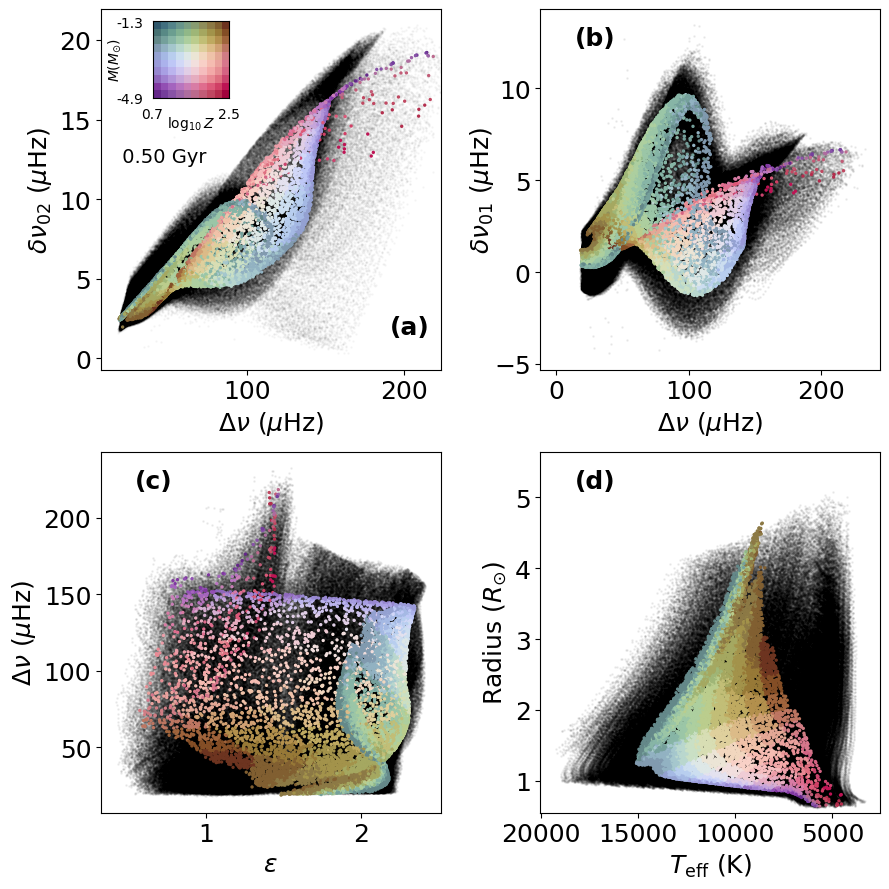

In [10]:
bivariate_d01d02eps(var1=massvar[keep_indices][age_cond],
              var2=fehvar[keep_indices][age_cond], 
              d01 = d01_scaler.inverse_transform(ss[:,2].reshape(-1,1)).squeeze()[age_cond],
              d02=10**ss[:,3][age_cond],
              eps = ss[:,5][age_cond],
              dnu=10**ss[:,1][age_cond],
              teff = 10**teff_scaler.inverse_transform(ss[:,0].reshape(-1,1)).squeeze()[age_cond],
              radius = 10**ss[:,-2][age_cond],
              conditional_name = '',
              conditional_unit = 'Gyr',
              conditional_val = np.round(age_select, 2),
              var1name = '$\\log_{10}Z$',
              var2name = '$M (M_{\\odot})$',
              colors = colors[keep_indices][age_cond],
              fs = 18,
              cmap=cmap)